In [215]:
# import
import matplotlib.pyplot as plt, mpld3
import numpy as np
import random
import re
import sys
import pprint
import collections

import time
import more_itertools as mit
from scipy import sparse
import pickle
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D


from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [74]:
def delete_row_csr(mat, i):
    if not isinstance(mat, sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    n = mat.indptr[i+1] - mat.indptr[i]
    if n > 0:
        mat.data[mat.indptr[i]:-n] = mat.data[mat.indptr[i+1]:]
        mat.data = mat.data[:-n]
        mat.indices[mat.indptr[i]:-n] = mat.indices[mat.indptr[i+1]:]
        mat.indices = mat.indices[:-n]
    mat.indptr[i:-1] = mat.indptr[i+1:]
    mat.indptr[i:] -= n
    mat.indptr = mat.indptr[:-1]
    mat._shape = (mat._shape[0]-1, mat._shape[1])
    
    return mat

In [184]:
def loadSetEqasym(pickleSet, multiFile):
    if multiFile == False:
        print('only multifile supported in loadSetEqasym')
        return A
    
    elif multiFile == True:
        # use this for partitioned sets: WS
        print('load block number n out of ' + str(405) + ': ')
        pickleSetMat = pickle.load( open(pickleSet + '/000.p', "rb" ) ) 
        print('0', end=' ')
        for j in range(1, 405): # bidentates
            # excluding last, start  at 1 bc WS/EA has not zeros in the first block 000.
            # ACHTUNG: EA monos have 000 in the first block :S
            tmp = pickle.load( open(pickleSet + '/' + str('{:03}'.format(j)) + '.p', "rb" ) )
            tmp = delete_row_csr(tmp, 0)
            pickleSetMat = sparse.vstack([pickleSetMat, tmp])
            print(j, end=' ')

        for j in range(405, 810): # monodentates (INCLUDING first #405 unlike #000, bc there is something) (excluding very last 811 which is eqasym ac bident, which has a first row to keep)
            tmp = pickle.load( open(pickleSet + '/' + str('{:03}'.format(j)) + '.p', "rb" ) )
            tmp = delete_row_csr(tmp, 0)
            pickleSetMat = sparse.vstack([pickleSetMat, tmp])
            print(j, end=' ')
        tmp = pickle.load( open(pickleSet + '/810.p', "rb" ) ) 
        pickleSetMat = sparse.vstack([pickleSetMat, tmp])
        print('810', end=' ')
        
        print('\nall blocks loaded')
        print('Shape of loaded:' + str(pickleSetMat.get_shape()))
        A = pickleSetMat.todense()

        print('loaded all')

        return A

In [146]:
def loadSet(pickleSet, multiFile):
    if multiFile == False:
        # use this for nonpartitioned sets
        pickleSet = pickle.load( open(pickleSet + '.p', "rb" ) )
        A = (sparse.csr_matrix.todense((pickleSet)))
        print('Shape of loaded:' + str(np.shape(A)))
        print('loaded all')
    
        return A
    
    elif multiFile == True:
        # use this for partitioned sets: WS
        print('load block number n out of ' + str(405) + ': ')
        pickleSetMat = pickle.load( open(pickleSet + '/weaksymMonodentates_000.p', "rb" ) ) 
        print('0', end=' ')
        for j in range(1, 405):
            # excluding last, start  at 1 bc WS/EA has not zeros in the first block 000.
            # ACHTUNG: EA monos have 000 in the first block :S
            tmp = pickle.load( open(pickleSet + '/weaksymMonodentates_' + str('{:03}'.format(j)) + '.p', "rb" ) )
            tmp = delete_row_csr(tmp, 0)
            pickleSetMat = sparse.vstack([pickleSetMat, tmp])
            print(j, end=' ')
        
        print('\nall blocks loaded')
        print('Shape of loaded:' + str(pickleSetMat.get_shape()))
        A = pickleSetMat.todense()

        print('loaded all')

        return A

In [4]:
# def deleteZeros(A, numberOfBlocks):
#     print('deleted zeros in blocks (bi): ')
#     for r in range(1,148): # bit murky. delete every first row of each block because there is a line of zeros (NOT the very first for ws tho)
#         print(A[r*81810])
# #         A = np.delete(A, r*81810, axis=0) 
#         print(r, end=' ')
#     print('deleted zeros in blocks (mono): ')
#     for r in range(148,553): # monodentates have other lengths
#         print(A[r*81406])
# #         A = np.delete(A, r*81406, axis=0) 
#         print(r, end=' ')
#     print('\ndeleted all zeros')

#     print('Shape of loaded:' + str(np.shape(A)))
    
#     return A

In [56]:
def plotCorrOfFeat(A):
    # 0               | 1       | 2        | 3                              | 4
    # charge1+charge2 | VE1+VE2 | EN of CA | \Delta \chi = \sum{EN1 - EN_i} | \Prod \chi = \sum{EN1 * EN_i} 
    labels = ['charge', 'VE', 'EN', 'chi prime', 'chi']
    k = 1
    for i in range(0, 5):
        plt.figure(figsize=(30,20))
        plt.subplots_adjust(wspace=1)
        for j in range(0,5): 
            plt.subplot(5, 5, k)
            plt.hist2d(np.asarray(A)[:,j], np.asarray(A)[:,i], cmap = 'Greys')
            plt.xlabel(labels[j])
            plt.ylabel(labels[i])
    #         plt.colorbar()

            k+=1

In [6]:
def calcEnt(A):
    print('entered ent')
    kernel = gaussian_kde(np.transpose(np.asarray(A)), bw_method='scott') # go np.asarray(A)[:,x:y] for ent of specific cols
    print('kernel done')
    sigma = kernel.covariance
    
    anaEnt = 0.5*np.log2(np.linalg.det(2*np.pi*np.exp(1)*sigma))
    empEnt = 0.5*np.log2(np.linalg.det(2*np.pi*np.exp(1)*np.diag(np.var(np.asarray(A),0)))) # see above
    
    print("Analytical Entropy: " + str(anaEnt))
    print("Empirical Entropy: " + str(empEnt))

In [7]:
def plotFit(name, A, a, b):
    m1 = np.asarray(A)[:,a]
    m2 = np.asarray(A)[:,b]
    # %matplotlib notebook
    xmin = m1.min()
    xmax = m1.max()
    ymin = m2.min()
    ymax = m2.max()

    X, Y = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    values = np.vstack([m1, m2])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)

    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X, Y, Z, s=2)
    plt.savefig(name + '_3Dhist.pdf')
    plt.show()
    
    
    fig, ax = plt.subplots()
    fig.set_figheight(10)
    fig.set_figwidth(10)
    ax.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[xmin, xmax, ymin, ymax], aspect='auto')
    ax.plot(m1, m2, 'k.', markersize=1)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    plt.savefig(name + '_headmap.pdf')
    plt.show()
    

    return X, Y, Z

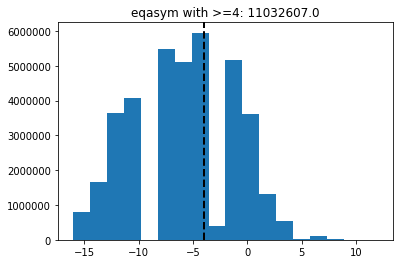

In [189]:
def plotChargeHist(A,name):
    hist = plt.hist(A[:,0], bins=18, cumulative=False)
    plt.axvline(-4, color='black', linestyle='dashed', linewidth=2)
    
    plt.savefig(name + "_chargeHist.pdf")

    sumOfReasonablyChargedCpl = 0
    for i in range(0, len(hist[1])-1):
        if hist[1][i] >= -4 and hist[1][i] <= 4:
            sumOfReasonablyChargedCpl += hist[0][i]
    
    plt.title(name + ' with >=4: ' + str(sumOfReasonablyChargedCpl))
plotChargeHist(Aea, 'eqasym')

In [247]:
def mergeTwo(name, A, B):
    a = pickle.load( open(A + '.p', "rb" ) ) 
    b = pickle.load( open(B + '.p', "rb" ) )
    print(a.get_shape())
    print(b.get_shape())
    
    # vstack for prop mat to stack, block_diag for proj mat to stack. 
    # merge = sparse.vstack([a, b])
    merge = sparse.block_diag([a, b])
    
    pickle.dump(merge, file=open(name + ".p", "wb"), protocol=2) 
    return merge 
merge = mergeTwo('homolepProj', 'homolepMonodentatesProj', 'homolepBidentatesProj')

a = pickle.load( open('homolepProj.p', "rb" ) ) 
print(a.get_shape())

(405, 405)
(148, 148)


In [155]:
def analyze(setname, multiFile):
    start_time = time.time()
    abbrevDict = {'Aho':'homolep', 'Afo':'fiveonesym', 'Ass':'strongsym', 'Aft':'fourtwosym', 'Aws':'weaksym', 'Aea':'eqasym', 'Aeaac_b':'eqasymAcBidentates',
                  'Aeaadc_b': 'eqasymAdcBidentates','Aeaadc': 'eqasymMonodentates'}
    print('analyzing: ' + abbrevDict[setname])
#     A = loadSet(abbrevDict[setname], multiFile)
    A = loadSetEqasym(abbrevDict[setname], multiFile)
    plotCorrOfFeat(A)
    calcEnt(A)
    print('Took ' + str(time.time() - start_time) + ' seconds')
    return A

entered ent
kernel done
Analytical Entropy: 10.544375594972708
Empirical Entropy: 26.48443749350564


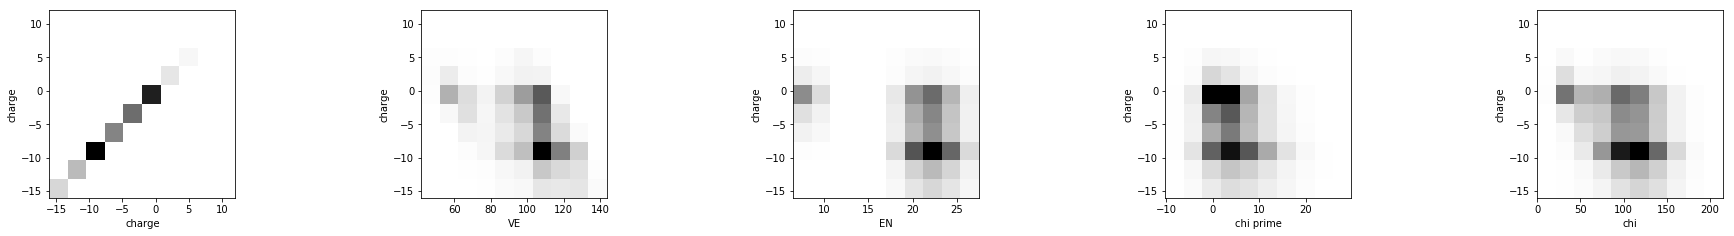

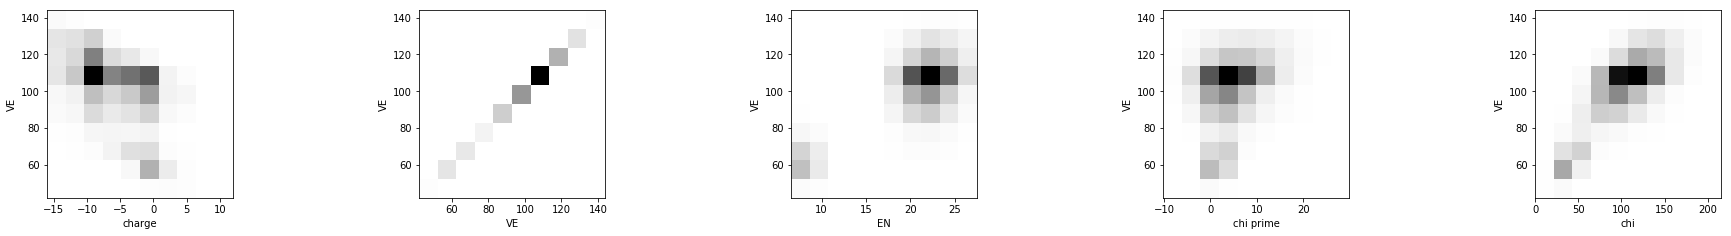

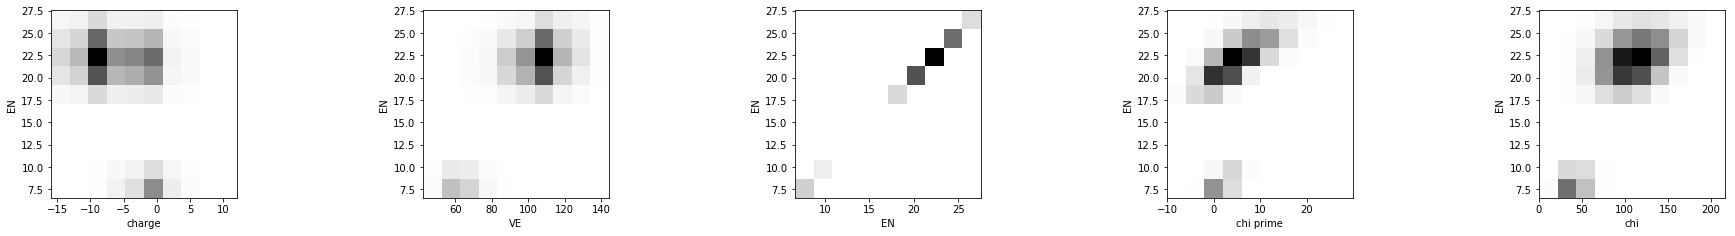

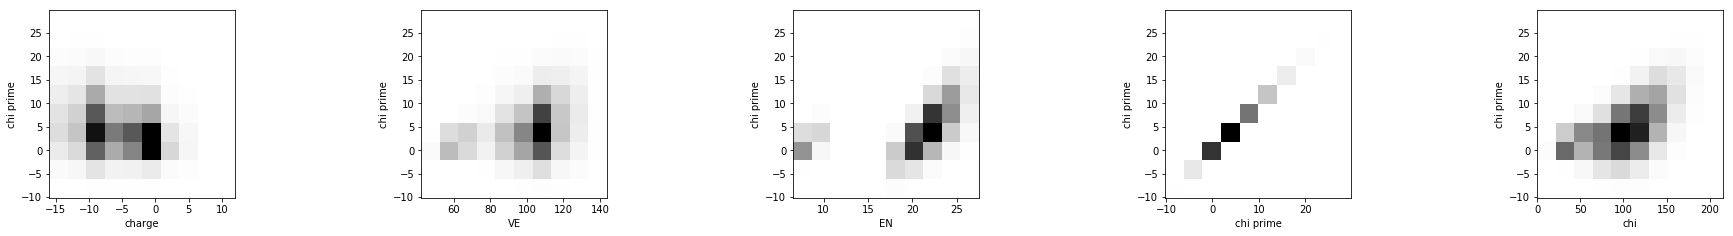

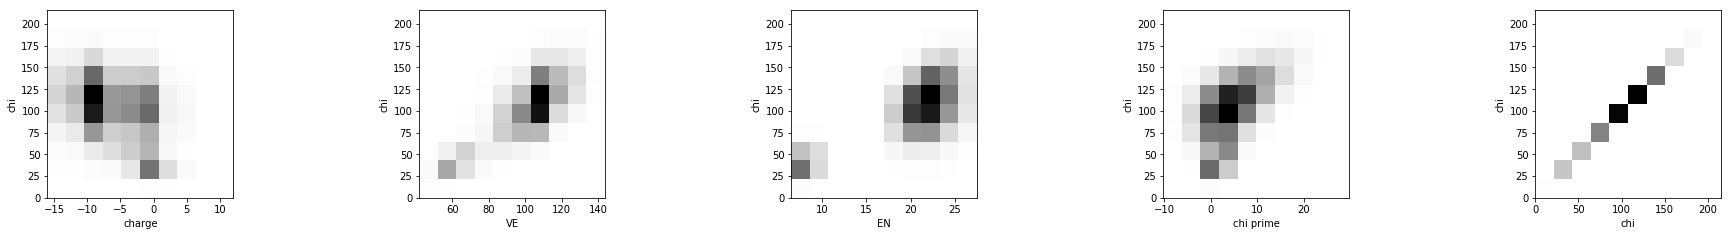

In [187]:
multiFile = True

# Aho, Afo, Ass, Aft, Aws, Aeaac_b, Aeaadc_b, Aeaadc
# Aea = analyze('Aea', multiFile)
plotCorrOfFeat(Aea)
calcEnt(Aea)

# Xh, Yh, Zh = plotFit("homolepMonodentates", Aws, 1, 4)

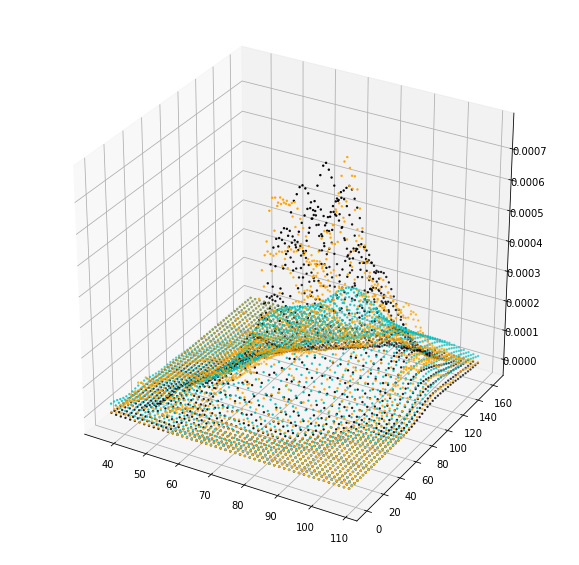

In [18]:
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs, Ys, Zs, s=2, color = 'k')
ax.scatter(Xs, Ys, Zh, s=2, color = 'c')
ax.scatter(Xs, Ys, Zf, s=2, color = 'orange')
# ax.scatter(Xs, Ys, Zw, s=2, color = 'y')

plt.show()